# CIFAR-10 Dataset

## Setup

In [18]:
!wget https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz -O ./data/cifar-10-python.tar.gz

^C


--2022-02-13 17:19:08--  https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 170498071 (163M) [application/x-gzip]
Saving to: './data/cifar-10-python.tar.gz'

     0K .......... .......... .......... .......... ..........  0%  197K 14m5s
    50K .......... .......... .......... .......... ..........  0%  415K 10m23s
   100K .......... .......... .......... .......... ..........  0% 1.10M 7m44s
   150K .......... .......... .......... .......... ..........  0%  526K 7m7s
   200K .......... .......... .......... .......... ..........  0%  394K 7m6s
   250K .......... .......... .......... .......... ..........  0%  417K 7m1s
   300K .......... .......... .......... .......... ..........  0%  673K 6m36s
   350K .......... .......... .......... .......... ..........  0%  904K 6m10s


In [ ]:
!tar -xzf ./data/cifar-10-python.tar.gz --directory ./data

In [1]:
!wget https://raw.githubusercontent.com/snatch59/load-cifar-10/master/load_cifar_10.py -O load_cifar_10.py

--2022-02-13 16:12:18--  https://raw.githubusercontent.com/snatch59/load-cifar-10/master/load_cifar_10.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 2606:50c0:8000::154, 2606:50c0:8003::154, 2606:50c0:8001::154, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|2606:50c0:8000::154|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4419 (4.3K) [text/plain]
Saving to: 'load_cifar_10.py'

     0K ....                                                  100%  194K=0.02s

2022-02-13 16:12:19 (194 KB/s) - 'load_cifar_10.py' saved [4419/4419]



In [9]:
import load_cifar_10

import cv2

from PIL import Image
from matplotlib import pyplot as plt
import numpy as np

import models

In [2]:
cifar_train_data, \
    cifar_train_filenames, \
    cifar_train_labels, \
    cifar_test_data, \
    cifar_test_filenames, \
    cifar_test_labels, \
    cifar_label_names = load_cifar_10.load_cifar_10_data("./data/cifar-10-batches-py")

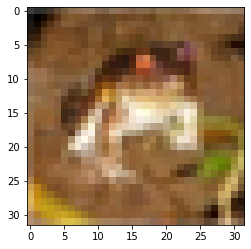

In [3]:
im = Image.fromarray(cifar_train_data[0])
plt.imshow(im)

## Simple feature extraction

In [4]:
# All this is stolen from TUWEL

def histogram_feature_extraction_easy(image_data):
    data = []
    for index, image in enumerate(image_data):
        imagePIL = Image.fromarray(image)
        imagePIL = imagePIL.convert('RGB')     
        featureVector=imagePIL.histogram()
        
        if (len(featureVector) != 768): # just a sanity check; with the transformation to RGB, this should never happen
            print("Unexpected length of feature vector: {} in image with index: {}".format(str(len(featureVector)), index))

        data.append((featureVector))
    return data

def histogram_feature_extraction_open_cv(image_data):
    dataOpenCV_1D=[]
    dataOpenCV_2D=[]
    dataOpenCV_3D=[]

    flatten = lambda l: [item for sublist in l for item in sublist]

    for index, image in enumerate(image_data):
        imagePIL = Image.fromarray(image)
        imagePIL = imagePIL.convert('RGB')
        imageOpenCV = np.array(imagePIL) 
        # Convert RGB to BGR 
        imageOpenCV = imageOpenCV[:, :, ::-1].copy() 

        # Now we split the image in the three channels, B / G / R
        chans = cv2.split(imageOpenCV)
        colors = ("b", "g", "r")

        # First we do also features per channel, but this time, we aggregate them into a smaller number of bins
        # I.e. we do not have 256 values per channel, but less
        featuresOpenCV_1D = []
        bins_1D=64
        for (chan, color) in zip(chans, colors): # we compute the histogram over each channel
            histOpenCV = cv2.calcHist([chan], [0], None, [bins_1D], [0, 256])
            featuresOpenCV_1D.extend(histOpenCV)
        featureVectorOpenCV_1D = flatten(featuresOpenCV_1D) # and append this to our feature vector
        
        dataOpenCV_1D.append(featureVectorOpenCV_1D) # now we append the feature vector to the dataset so far

        if (len(featureVectorOpenCV_1D) != bins_1D*3): # sanity check, in case we had a wrong number of channels...
            print("Unexpected length of feature vector: {} with index: {}".format(str(len(featureVectorOpenCV_1D)), index))

        # Next - features that look at two channels at the same time
        # E.g. we look at when green and blue have both "high values"
        # We reduce the size of bins further, to not have a too long feature vector
        featuresOpenCV_2D = []
        bins2D=16
        # look at all combinations of channels (R & B, R & G, B & G)
        featuresOpenCV_2D.extend(cv2.calcHist([chans[1], chans[0]], [0, 1], None, [bins2D, bins2D], [0, 256, 0, 256]))
        featuresOpenCV_2D.extend(cv2.calcHist([chans[1], chans[2]], [0, 1], None, [bins2D, bins2D], [0, 256, 0, 256]))
        featuresOpenCV_2D.extend(cv2.calcHist([chans[0], chans[2]], [0, 1], None, [bins2D, bins2D], [0, 256, 0, 256]))
        # and add that to our dataset
        featureVectorOpenCV_2D = flatten(featuresOpenCV_2D)
        dataOpenCV_2D.append(featureVectorOpenCV_2D)

        # finally, we look at all three channels at the same time.
        # We further reduce our bin size, because otherwise, this would become very large...
        featuresOpenCV_3D = cv2.calcHist([imageOpenCV], [0, 1, 2], None, [8, 8, 8], [0, 256, 0, 256, 0, 256])
        # append to our dataset
        featureVectorOpenCV_3D = featuresOpenCV_3D.flatten()
        dataOpenCV_3D.append(featureVectorOpenCV_3D)

    return dataOpenCV_1D, dataOpenCV_2D, dataOpenCV_3D
    

In [5]:
train_easy = histogram_feature_extraction_easy(cifar_train_data)
train_dataOpenCV_1D, train_dataOpenCV_2D, train_dataOpenCV_3D = histogram_feature_extraction_open_cv(cifar_train_data)

In [6]:
test_easy = histogram_feature_extraction_easy(cifar_test_data)
test_dataOpenCV_1D, test_dataOpenCV_2D, test_dataOpenCV_3D = histogram_feature_extraction_open_cv(cifar_test_data)

In [10]:
data_sets = [
    (train_easy, test_easy, "./results/cifar_10_easy_{}"),
    (train_dataOpenCV_1D, test_dataOpenCV_1D, "./results/cifar_10_opencv_1D_{}"),
    (train_dataOpenCV_2D, test_dataOpenCV_2D, "./results/cifar_10_opencv_2D_{}"),
    (train_dataOpenCV_3D, test_dataOpenCV_3D, "./results/cifar_10_opencv_3D_{}")
]

models = [
    models.do_logistic_regression,
    models.do_lda,
    models.do_svm,
    models.do_mlp
]

C:\Users\Paul\miniconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Classification report for Logistic Regression
Accuracy score: 0.242
Recall score: 0.242
Precision score: 0.23346884918631478


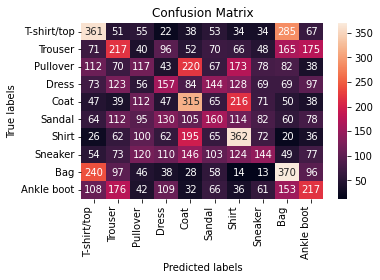

C:\Users\Paul\miniconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Classification report for Logistic Regression
Accuracy score: 0.2687
Recall score: 0.2687
Precision score: 0.25982791633141317


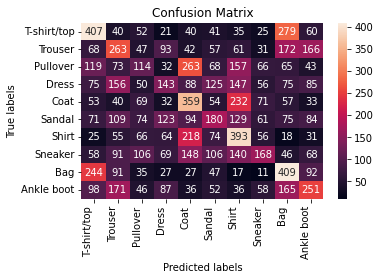

C:\Users\Paul\miniconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Classification report for Logistic Regression
Accuracy score: 0.3188
Recall score: 0.3188
Precision score: 0.3131588882371475


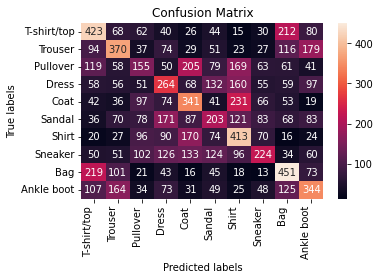

C:\Users\Paul\miniconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Classification report for Logistic Regression
Accuracy score: 0.3183
Recall score: 0.3183
Precision score: 0.31209831352995365


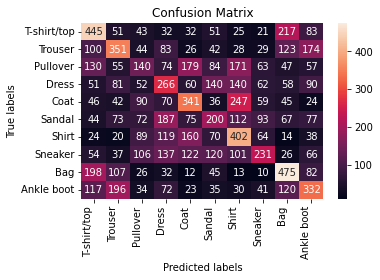

Classification report for LDA
Accuracy score: 0.2426
Recall score: 0.2426
Precision score: 0.23298492247977826


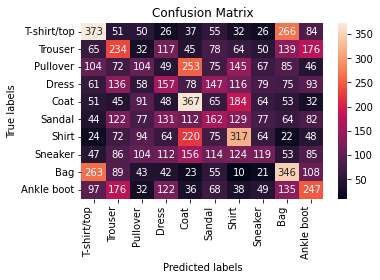

Classification report for LDA
Accuracy score: 0.2615
Recall score: 0.2615
Precision score: 0.25166290040967165


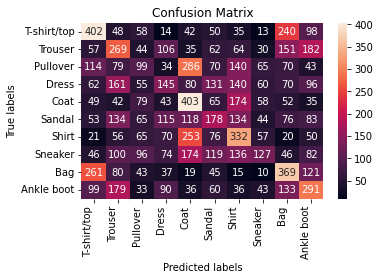

Classification report for LDA
Accuracy score: 0.3071
Recall score: 0.3071
Precision score: 0.3028002427888658


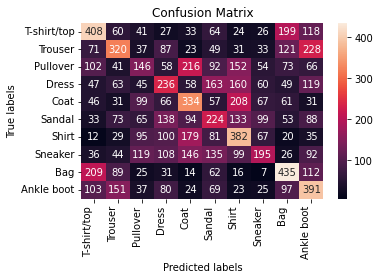

Classification report for LDA
Accuracy score: 0.301
Recall score: 0.301
Precision score: 0.298115346168436


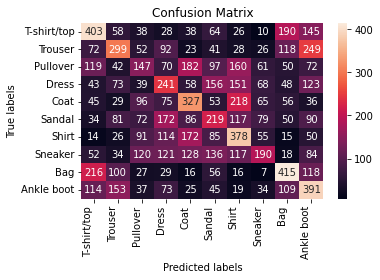

In [11]:
for model in models:
    for (train, test, path) in data_sets:
        model(train, cifar_train_labels, test, cifar_test_labels, path)